In [1]:
### Goals
# 1. Create simple teams 
# 2. Have simple/damage bots battle with teams
# 3. Understand action space
# 4. Get dummy net to take actions in battle

"""
Run prior to NB:

cd pokemon-showdown
cp config/config-example.js config/config.js
node pokemon-showdown start --no-security
"""

'\nRun prior to NB:\n\ncd pokemon-showdown\ncp config/config-example.js config/config.js\nnode pokemon-showdown start --no-security\n'

In [2]:
import asyncio
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import deque
from tqdm import tqdm
import matplotlib.pyplot as plt

# Tring to squelch bad poke-env move outputs (e.g.: locked into outrage)
import logging
logging.getLogger("poke_env").setLevel(logging.CRITICAL)

# Global variable for coarse graining hp states
NUM_HP_BINS = 4

In [3]:
from poke_env import Player, RandomPlayer
from simple_dqn import DQN

In [4]:
# From poke-env docs

class MaxDamagePlayer(Player):
    def choose_move(self, battle):
        # Chooses a move with the highest base power when possible
        if battle.available_moves:
            # Iterating over available moves to find the one with the highest base power
            best_move = max(battle.available_moves, key=lambda move: move.base_power)
            # Creating an order for the selected move
            return self.create_order(best_move)
        else:
            # If no attacking move is available, perform a random switch
            # This involves choosing a random move, which could be a switch or another available action
            return self.choose_random_move(battle)

In [5]:
class DebugPlayer(RandomPlayer):
    def choose_move(self, battle):
        # Print turn number
        print(f"Turn: {battle.turn}")

        # Print available moves
        print(f"Available moves: {[move.id for move in battle.available_moves]}")

        # Check battle has started
        your_pokemon = battle.active_pokemon
        opponent_pokemon = battle.opponent_active_pokemon
 
        # Extract key battle info
        state = {
            #"turn": battle.turn,
            "your_hp": int(NUM_HP_BINS * battle.active_pokemon.current_hp_fraction) / NUM_HP_BINS if your_pokemon else None,
            "your_status": battle.active_pokemon.status if your_pokemon else None,
            "your_moves": [move.id for move in battle.available_moves] if your_pokemon else None,
            "opponent_hp": int(NUM_HP_BINS * battle.opponent_active_pokemon.current_hp_fraction) / NUM_HP_BINS if opponent_pokemon else None,
            "opponent_status": battle.opponent_active_pokemon.status if opponent_pokemon else None
        }

        # Get type effectiveness
        moves_dmg_multiplier = np.ones(4)
        if battle.opponent_active_pokemon:
            for i, move in enumerate(battle.available_moves):
                if move.type:
                    moves_dmg_multiplier[i] = battle.opponent_active_pokemon.damage_multiplier(move)

        # Print the state info
        # print(f"State: {state}")

        return super().choose_move(battle)  # Act as a random player

In [6]:
# adjusted from poke-env docs
# dummy player that observes the battle and passes state to dqn for random action

class DummyRLPlayer(Player):
    def __init__(self, model, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.model = model  # Store DQN model
        
    def choose_move(self, battle):
        # Check battle has started and get hp's
        your_pokemon = battle.active_pokemon
        opponent_pokemon = battle.opponent_active_pokemon

        your_hp = int(NUM_HP_BINS * battle.active_pokemon.current_hp_fraction) / NUM_HP_BINS if your_pokemon else -1
        opponent_hp = int(NUM_HP_BINS * battle.opponent_active_pokemon.current_hp_fraction) / NUM_HP_BINS if opponent_pokemon else -1

        # Get available move powers
        # -1 indicates that the move does not have a base power
        # or is not available
        moves_base_power = -np.ones(4)
        moves_dmg_multiplier = np.ones(4)
        if battle.opponent_active_pokemon:
            for i, move in enumerate(battle.available_moves):
                moves_base_power[i] = (
                    move.base_power / 100
                )  # Simple rescaling to facilitate learning
                if move.type:
                    moves_dmg_multiplier[i] = battle.opponent_active_pokemon.damage_multiplier(move)

        # test if state has worked correctly
        state = np.concatenate(
            [
                moves_base_power,
                moves_dmg_multiplier,
                [your_hp, opponent_hp],
            ]
        )

        # Create state vector
        state = np.concatenate([moves_base_power, moves_dmg_multiplier, [your_hp, opponent_hp]])
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)  # Convert to tensor

        # Get Q-values from DQN
        with torch.no_grad():
            q_values = self.model(state_tensor)

        # "Best" move is just random b/c dqn doesn't train
        best_move_idx = torch.argmax(q_values).item()
        available_moves = battle.available_moves

        # Simple check, doesn't factor pp yet
        if available_moves and best_move_idx < len(available_moves):
            return self.create_order(available_moves[best_move_idx])
        else:
            return self.choose_random_move(battle)  # Fallback if move index is invalid


    def compute_reward(self, battle) -> float:
        pass

In [ ]:
# Testing simple RL player
# add dqn model to player class

class SimpleRLPlayer(Player):
    def __init__(self, model, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.model = model
        self.memory = deque(maxlen=10000)  # Experience replay buffer
        self.gamma = 0.99
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)
        
    def choose_move(self, battle):
        # Convert battle state into a vector
        state = self.get_state_vector(battle)
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)

        # Get Q-values and pick best move
        with torch.no_grad():
            q_values = self.model(state_tensor)
        
        # Best move now informed by RL
        best_move_idx = torch.argmax(q_values).item()
        available_moves = battle.available_moves

        # Compute reward for action
        reward = self.compute_reward(battle)
        next_state = self.get_state_vector(battle)  # Next state (after move)
        done = battle.finished  # Check if the battle is over
        action_idx = best_move_idx  # Action taken

        # Store state-action
        self.memory.append((state, action_idx, reward, next_state, done))

        # Simple check, doesn't factor pp yet
        if available_moves and best_move_idx < len(available_moves):
            return self.create_order(available_moves[best_move_idx])
        else:
            return self.choose_random_move(battle)  # Fallback move
        
    def get_state_vector(self, battle):
        ### Convert battle info to state vector
        # State info is very simple atm
        # move bp, type effectiveness, and hp values
        your_pokemon = battle.active_pokemon
        opponent_pokemon = battle.opponent_active_pokemon

        your_hp = int(NUM_HP_BINS * battle.active_pokemon.current_hp_fraction) / NUM_HP_BINS if your_pokemon else -1
        opponent_hp = int(NUM_HP_BINS * battle.opponent_active_pokemon.current_hp_fraction) / NUM_HP_BINS if opponent_pokemon else -1

        moves_base_power = -np.ones(4)
        moves_dmg_multiplier = np.ones(4)

        if battle.opponent_active_pokemon:
            for i, move in enumerate(battle.available_moves):
                moves_base_power[i] = move.base_power / 100
                if move.type:
                    moves_dmg_multiplier[i] = battle.opponent_active_pokemon.damage_multiplier(move)

        return np.concatenate([moves_base_power, moves_dmg_multiplier, [your_hp, opponent_hp]])

    def train(self, batch_size=32):
        ###Updates the DQN model using stored experience
        if len(self.memory) < batch_size:
            return  # Don't train until we have enough experiences

        batch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.tensor(np.array(states), dtype=torch.float32)
        actions = torch.tensor(np.array(actions), dtype=torch.int64).unsqueeze(1)
        rewards = torch.tensor(np.array(rewards), dtype=torch.float32).unsqueeze(1)
        next_states = torch.tensor(np.array(next_states), dtype=torch.float32)
        dones = torch.tensor(np.array(dones), dtype=torch.float32).unsqueeze(1)

        # Compute current Q-values
        q_values = self.model(states).gather(1, actions)

        # Compute next Q-values using target network
        with torch.no_grad():
            next_q_values = self.model(next_states).max(1)[0].unsqueeze(1)

        target_q_values = rewards + (self.gamma * next_q_values * (1 - dones))

        # Compute loss and update model
        loss = F.mse_loss(q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def compute_reward(self, battle) -> float:
        reward = 0

        # Reward for reducing opponent HP
        if battle.opponent_active_pokemon:
            reward += np.power((1 - battle.opponent_active_pokemon.current_hp_fraction), 1) * 1

        # Reward for maintaining hp
        if battle.active_pokemon:
            reward += np.power((battle.active_pokemon.current_hp_fraction), 1) * 1

        # Reward for dealing the final blow
        # if battle.opponent_active_pokemon and battle.opponent_active_pokemon.fainted:
        #    reward += 10

        # Reward for winning
        if battle.won:
            #print("win")
            reward += 100

        return reward

In [8]:
# Notes:
# must have some EV's on mons
# would be nice to check if mon is valid without losing kernel

team_1 = """
Charizard @ Heavy-Duty Boots
Ability: Blaze
EVs: 252 SpA / 4 SpD / 252 Spe
Timid Nature
- Roost
- Flamethrower
- Hurricane
- Toxic
"""
team_2 = """
Venusaur @ Life Orb
Ability: Chlorophyll
EVs: 252 SpA / 4 SpD / 252 Spe
Modest Nature
- Growth
- Giga Drain
- Weather Ball
- Sludge Bomb
"""
team_char = """
Charmander @ Leftovers
Ability: Blaze
EVs: 252 SpA / 4 SpD / 252 Spe
Adamant Nature
- Air Cutter
- Belly Drum
- Cut
- Ember
"""
team_embchar = """
Charmander @ Leftovers
Ability: Blaze
EVs: 252 SpA / 4 SpD / 252 Spe
Adamant Nature
- Ember
"""
team_bulb = """
Bulbasaur @ Leftovers
Ability: Overgrow
EVs: 252 SpA / 4 SpD / 252 Spe
Adamant Nature
- Amnesia
- Energy Ball
- Outrage
- Charm
"""
team_squir = """
Squirtle @ Leftovers
Ability: Rain Dish
EVs: 252 SpA / 4 SpD / 252 Spe
Adamant Nature
- Aqua Jet
- Bite
- Shell Smash
- Hail
"""
team_bliss = """
Blissey @ Heavy-Duty Boots
Ability: Natural Cure
EVs: 252 HP / 252 Def / 4 SpD
Bold Nature
- Seismic Toss
- Soft-Boiled
- Charm
- Disarming Voice
"""
team_champ = """
Machop @ Choice Scarf
Ability: Guts
EVs: 252 HP / 252 Def / 4 SpD
Bold Nature
- Brick Break
"""

In [9]:
async def random_player_battle(team_1, team_2, n_battles):
    p1 = DebugPlayer(battle_format="gen8ou", team=team_1)
    p2 = RandomPlayer(battle_format="gen8ou", team=team_2)

    await p1.battle_against(p2, n_battles=n_battles)

    for battle_tag, battle in p1.battles.items():
        won_txt = "lost"
        if battle.won:
            won_txt = "won"
        print("player 1 played battle: ", battle_tag, " and ", won_txt)

In [10]:
async def maxdam_player_battle(team_1, team_2, n_battles):
    p3 = MaxDamagePlayer(battle_format="gen8ou", team=team_1)
    p4 = MaxDamagePlayer(battle_format="gen8ou", team=team_2)

    await p3.battle_against(p4, n_battles=n_battles)

    for battle_tag, battle in p3.battles.items():
        won_txt = "lost"
        if battle.won:
            won_txt = "won"
        print("player 3 played battle: ", battle_tag, " and ", won_txt)

In [11]:
# Runs one battle with players in showdown local server
test = False

if test:
    #p1 = DebugPlayer(battle_format="gen8ou", team=team_bulb)
    model = DQN() 
    p1 = SimpleRLPlayer(model, battle_format="gen8ou", team=team_bliss)
    p2 = RandomPlayer(battle_format="gen8ou", team=team_bliss)

    await p1.battle_against(p2, n_battles=1)

    for battle_tag, battle in p1.battles.items():
        won_txt = "lost"
        if battle.won:
            won_txt = "won"
        print("player 1 played battle: ", battle_tag, " and ", won_txt)

In [12]:
model = DQN()
agent = SimpleRLPlayer(model, battle_format="gen8ou", team=team_bliss)
opponent = RandomPlayer(battle_format="gen8ou", team=team_champ)

NUM_EPISODES = 1000
NUM_BATTLES = 1

n_won_battles = 0
win_rates = []
batch_n_won_battles = 0
batch_win_rates = []
episode_rewards = []

for episode in tqdm(range(NUM_EPISODES), desc="Training Progress"):
    await agent.battle_against(opponent, n_battles=NUM_BATTLES)

    total_reward = 0

    # Save the experience
    for battle in agent.battles.values():
        state = agent.get_state_vector(battle)
        reward = agent.compute_reward(battle)
        next_state = agent.get_state_vector(battle)  # Next state (same for now)
        done = battle.finished  # Check if battle ended
        action = 0  # Placeholder (fix later)
        agent.memory.append((state, action, reward, next_state, done))
        #total_reward += reward  # Sum rewards for this episode
        total_reward += sum(r for _, _, r, _, _ in agent.memory)

    # Train the model
    agent.train(batch_size=32)

    # Check in on outputs
    if episode < -50:
        print(f"Episode {episode} - {agent.n_won_battles}")

    # Store win rate
    n_won_battles += agent.n_won_battles
    win_rate = n_won_battles / (NUM_BATTLES * (episode + 1))
    win_rates.append(win_rate)
    
    # Store total reward for episode
    episode_rewards.append(total_reward)

    # Reset battles
    agent.reset_battles()

# Save trained model if desired
#torch.save(model.state_dict(), "dqn_model.pth")


Training Progress:   2%|▏         | 20/1000 [00:00<00:23, 42.05it/s]

win
win


Training Progress:   5%|▍         | 48/1000 [00:00<00:15, 63.40it/s]

win
win


Training Progress:   6%|▌         | 62/1000 [00:01<00:14, 64.64it/s]

win


Training Progress:  10%|▉         | 95/1000 [00:01<00:11, 75.44it/s]

win


Training Progress:  11%|█▏        | 113/1000 [00:01<00:11, 78.17it/s]

win
win


Training Progress:  14%|█▍        | 138/1000 [00:02<00:11, 71.88it/s]

win


Training Progress:  16%|█▋        | 165/1000 [00:02<00:10, 80.11it/s]

win


Training Progress:  20%|█▉        | 199/1000 [00:02<00:11, 71.62it/s]

win


Training Progress:  22%|██▏       | 215/1000 [00:03<00:10, 73.20it/s]

win
win


Training Progress:  26%|██▌       | 258/1000 [00:03<00:10, 72.82it/s]

win
win
win


Training Progress:  32%|███▏      | 317/1000 [00:04<00:11, 61.54it/s]

win
win


Training Progress:  33%|███▎      | 332/1000 [00:05<00:10, 65.38it/s]

win
win


Training Progress:  35%|███▌      | 354/1000 [00:05<00:09, 65.81it/s]

win


Training Progress:  38%|███▊      | 380/1000 [00:05<00:08, 75.48it/s]

win
win


Training Progress:  40%|███▉      | 396/1000 [00:05<00:07, 77.24it/s]

win


Training Progress:  41%|████▏     | 413/1000 [00:06<00:07, 78.52it/s]

win
win
win


Training Progress:  43%|████▎     | 431/1000 [00:06<00:07, 79.82it/s]

win
win
win
win


Training Progress:  46%|████▌     | 456/1000 [00:06<00:07, 74.19it/s]

win


Training Progress:  52%|█████▏    | 524/1000 [00:07<00:06, 72.46it/s]

win
win
win


Training Progress:  55%|█████▍    | 549/1000 [00:07<00:05, 76.41it/s]

win


Training Progress:  57%|█████▋    | 573/1000 [00:08<00:05, 75.52it/s]

win
win
win


Training Progress:  61%|██████    | 606/1000 [00:08<00:05, 77.33it/s]

win
win
win


Training Progress:  62%|██████▏   | 622/1000 [00:08<00:05, 67.24it/s]

win
win


Training Progress:  65%|██████▌   | 652/1000 [00:09<00:05, 68.50it/s]

win


Training Progress:  68%|██████▊   | 677/1000 [00:09<00:04, 75.30it/s]

win
win
win
win


Training Progress:  69%|██████▉   | 693/1000 [00:09<00:04, 70.49it/s]

win
win
win


Training Progress:  73%|███████▎  | 733/1000 [00:10<00:03, 76.42it/s]

win


Training Progress:  76%|███████▋  | 765/1000 [00:10<00:03, 71.85it/s]

win


Training Progress:  78%|███████▊  | 781/1000 [00:11<00:02, 74.22it/s]

win
win
win
win
win


Training Progress:  80%|███████▉  | 797/1000 [00:11<00:02, 75.28it/s]

win


Training Progress:  82%|████████▏ | 822/1000 [00:11<00:02, 65.29it/s]

win
win


Training Progress:  86%|████████▌ | 855/1000 [00:12<00:01, 75.44it/s]

win
win
win
win


Training Progress:  89%|████████▉ | 893/1000 [00:12<00:01, 67.39it/s]

win


Training Progress:  91%|█████████ | 909/1000 [00:13<00:01, 71.78it/s]

win
win
win
win


Training Progress:  94%|█████████▍| 941/1000 [00:13<00:00, 76.67it/s]

win


Training Progress:  99%|█████████▉| 989/1000 [00:14<00:00, 72.98it/s]

win
win


Training Progress: 100%|██████████| 1000/1000 [00:14<00:00, 70.28it/s]

win
win
win


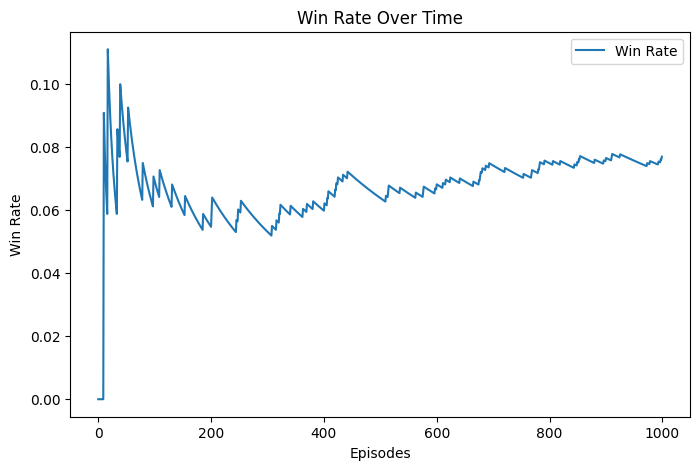

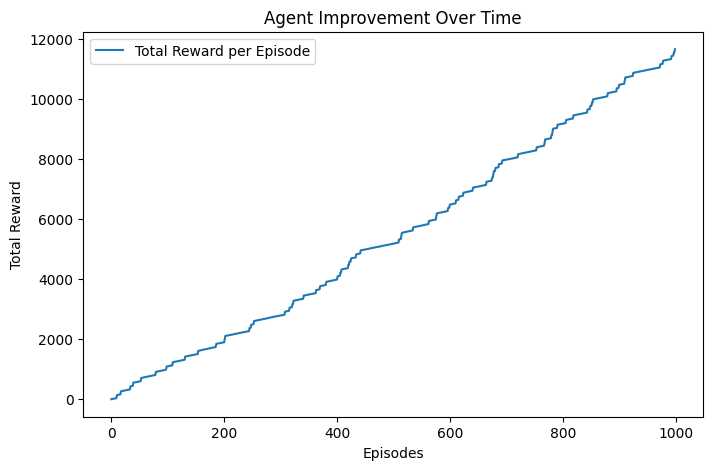

In [13]:
# Plot Win Rate Over Time
plt.figure(figsize=(8, 5))
plt.plot(range(NUM_EPISODES), win_rates, label="Win Rate")
plt.xlabel("Episodes")
plt.ylabel("Win Rate")
plt.title("Win Rate Over Time")
plt.legend()
plt.show()

# Plot Reward Over Time
plt.figure(figsize=(8, 5))
plt.plot(range(NUM_EPISODES), episode_rewards, label="Total Reward per Episode")
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.title("Agent Improvement Over Time")
plt.legend()
plt.show()